## Regression Trees, Random Forests

---

**Contents:**
* Fitting a simple CART with different stopping rules
* Pruning with CV and using a Minimal Cost-Complexity
* Fitting a random forest; adding extra randomization 
* Investigating importance of features in explaining the data 
* Comparing the performance of CART/RF models with that of OLS and LASSO

---

In [69]:
# Packages to import 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn import tree as tree


This is the data on house prices in California. The dataset contains median home values for about 20K census tracks in California. 

Available variables:
* Latitude and longitude of tract centers
* Total population and number of households
* Median income
* Average age of houses, total rooms, total bedrooms

In [70]:
df = pd.read_csv(r"C:\Users\johnd\OneDrive\Desktop\ML lecture\lecture6\data\CAhousing.csv")
df.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [71]:
df.describe()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.898014,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.247906,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [72]:
# Before the analysis, we do some transformations. 
# we add variables AveRooms, AveBedrooms, AveOccupancy (assumption: one household lives in one house)

df['aveRooms'] = df['totalRooms']/df['households']
df['aveBedrooms'] = df['totalBedrooms']/df['households']
df['aveOccupancy'] = df['population']/df['households']

df_new = df[['longitude', 'latitude', 'housingMedianAge', 'aveRooms', 'aveBedrooms', 'aveOccupancy', 'medianIncome', 'medianHouseValue']]


In [73]:
df_new.describe()

,longitude,latitude,housingMedianAge,aveRooms,aveBedrooms,aveOccupancy,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,5.429000,1.096675,3.070655,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2.474173,0.473911,10.386050,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,0.846154,0.333333,0.692308,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,4.440716,1.006079,2.429741,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,5.229129,1.048780,2.818116,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,6.052381,1.099526,3.282261,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,141.909091,34.066667,1243.333333,15.000100,500001.000000


<AxesSubplot:>

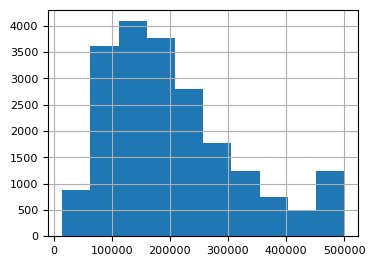

In [74]:
df_new['medianHouseValue'].hist()
# as we can see there are some large outliers of medianHouseValue. Therefore, a log transformation seems reasonable. 

In [75]:
# we try to see the difference in outputs with and without log transformation

# we create two datasets, one where only median housevalue is logged, other with multiple values logged
df_ylog = df_new.copy()
df_logged = df_new.copy()

for i in ['medianHouseValue']:
    df_ylog[i] = np.log(df_ylog[i])

for i in ['medianHouseValue', 'aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']:
    df_logged[i] = np.log(df_logged[i])

In [76]:
df_ylog.describe() # only median house value logged

,longitude,latitude,housingMedianAge,aveRooms,aveBedrooms,aveOccupancy,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,5.429000,1.096675,3.070655,3.870671,12.084884
std,2.003532,2.135952,12.585558,2.474173,0.473911,10.386050,1.899822,0.569134
min,-124.350000,32.540000,1.000000,0.846154,0.333333,0.692308,0.499900,9.615739
25%,-121.800000,33.930000,18.000000,4.440716,1.006079,2.429741,2.563400,11.691908
50%,-118.490000,34.260000,29.000000,5.229129,1.048780,2.818116,3.534800,12.099044
75%,-118.010000,37.710000,37.000000,6.052381,1.099526,3.282261,4.743250,12.486447
max,-114.310000,41.950000,52.000000,141.909091,34.066667,1243.333333,15.000100,13.122365


<AxesSubplot:>

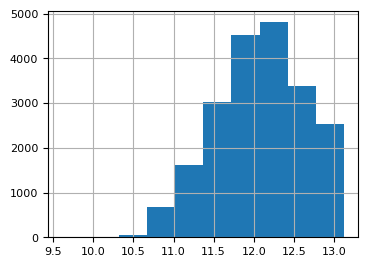

In [77]:
df_logged.describe()  # medianincome long lat not logged
df_ylog['medianHouseValue'].hist()

### Fitting a CART model
* Data is split into train test samples

Tree depth: 20
Out-of-sample Rsq: 0.765
Out-of-sample MSE: 0.077


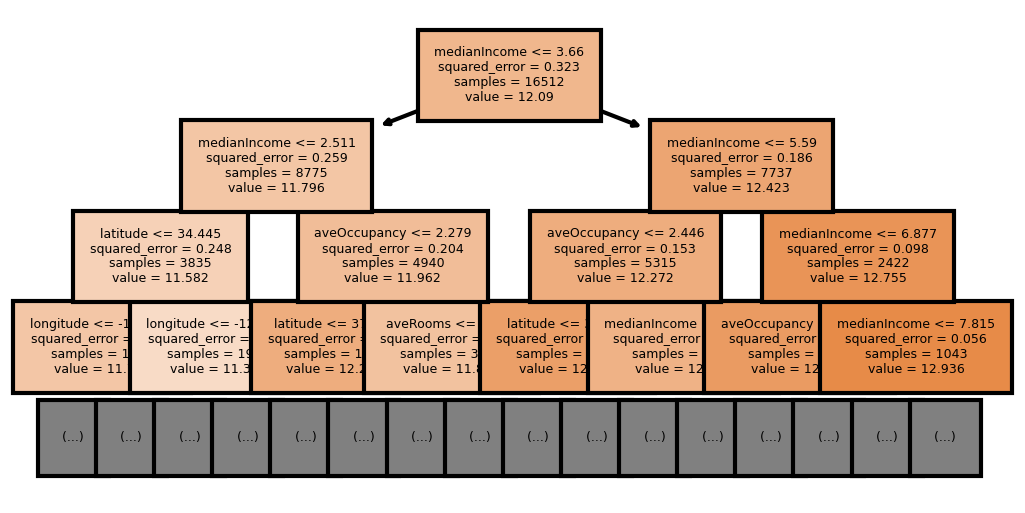

In [78]:
# first we use df_ylog

y = df_ylog['medianHouseValue']
X = df_ylog.iloc[:,:7]

#split into train and test, 80:20 split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

# set your own parameters to stabilize the tree
# there is no strong opinion on what stopping rule you should use; may differ across datasets you have. 
# Matt Taddy suggests to use min_sample_leaf, as it seems to set a simple and a transparent rule.

cart = tree.DecisionTreeRegressor(criterion='squared_error', min_samples_leaf=10, min_samples_split=10, random_state=1)
cart = cart.fit(X_train,y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300}) # set's parameters of the figure
tree.plot_tree(cart, max_depth = 3, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

### Pruning with Cross-Validation

In [79]:
from sklearn.model_selection import cross_validate
import scipy as sp

def cv_iter(max_depth, max_leaf_nodes, min_samples_leaf, folds, X, y):
    kf= KFold(n_splits=folds, shuffle=True, random_state=1)
    cart= tree.DecisionTreeRegressor(max_depth = max_depth, max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, random_state = 1) # settings for CART
    cv_result= cross_validate(cart,X,y, scoring = 'neg_mean_squared_error') # output for CV, scoring = what is returned)
    avg_score= np.mean(cv_result['test_score']) #average resutl for our N-folds
    return float(-avg_score)

13

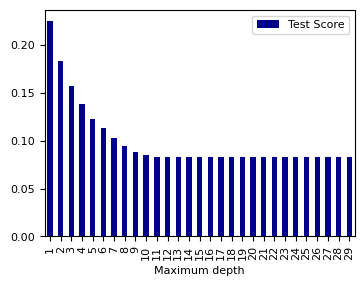

In [80]:
# Result when we iterate over candidate models of different depth

result = {}
for i in range(1, 30):
    result[i] = cv_iter(i, None, 10, 5, X_train, y_train) 
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot.bar(color = 'DarkBlue', xlabel = 'Maximum depth')

results['Test Score'].idxmin()

Tree depth: 13
Out-of-sample Rsq: 0.767
Out-of-sample MSE: 0.077


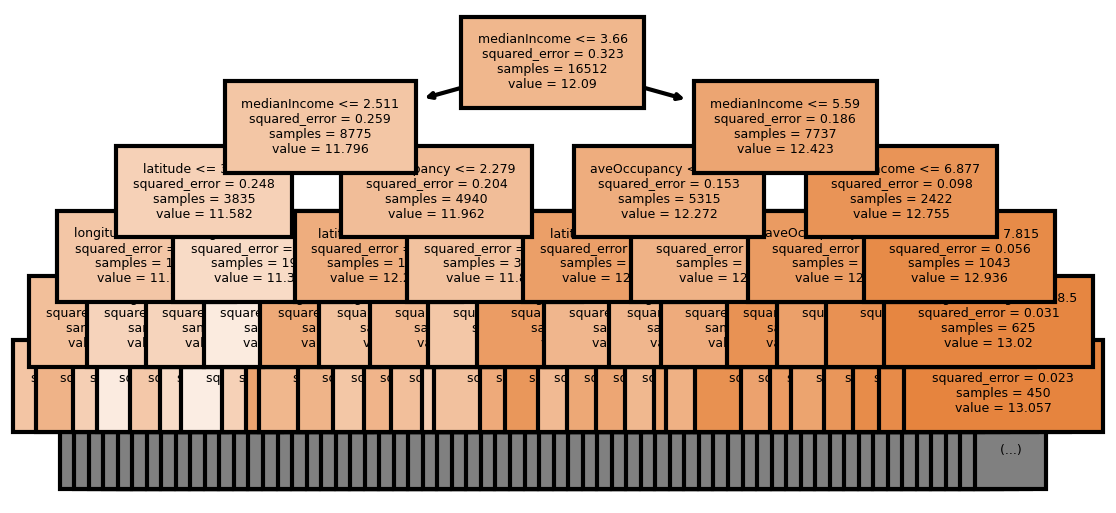

In [81]:
# fitting CART model based on above cv results
cart = tree.DecisionTreeRegressor(criterion='squared_error', max_depth =results['Test Score'].idxmin(), min_samples_leaf=10, min_samples_split=10, random_state=1)
cart = cart.fit(X_train,y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300}) # set's parameters of the figure
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

# here we see a slight improvement in fit but mse remains same

29

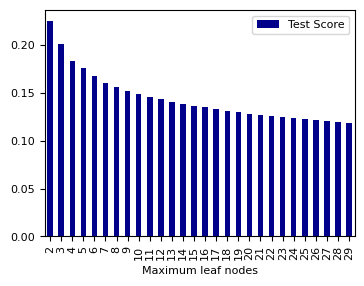

In [82]:
# Result when we iterate over candidate models of different leaf nodes

result = {}
for i in range(2, 30):
    result[i] = cv_iter(None, i, 10, 5, X_train, y_train) 
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot.bar(color = 'DarkBlue', xlabel = 'Maximum leaf nodes')

results['Test Score'].idxmin()

Tree depth: 7
Out-of-sample Rsq: 0.637
Out-of-sample MSE: 0.119


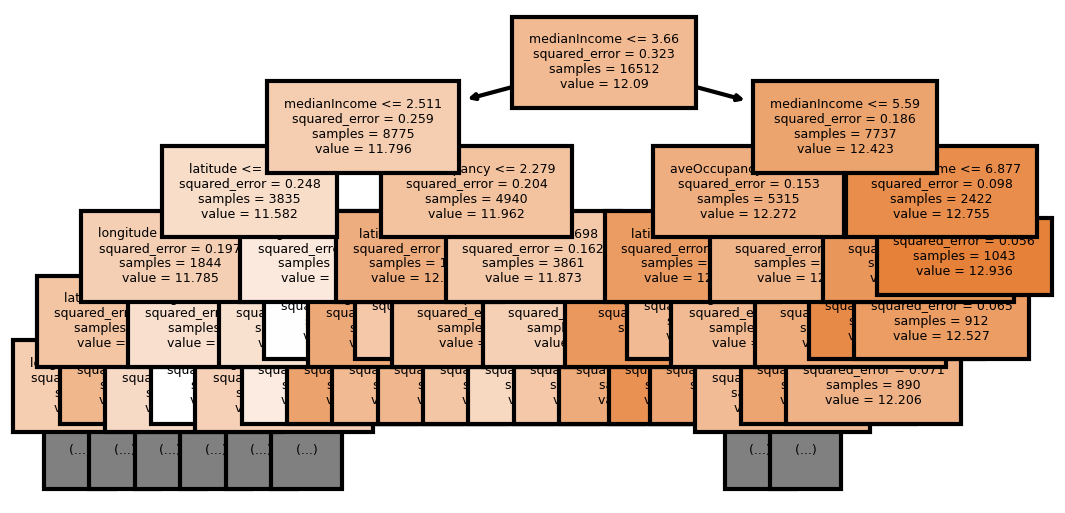

In [83]:
# fitting CART model based on above cv results
cart = tree.DecisionTreeRegressor(criterion='squared_error', max_leaf_nodes =results['Test Score'].idxmin(), min_samples_leaf=10, min_samples_split=10, random_state=1)
cart = cart.fit(X_train,y_train)

y_pred = cart.predict(X_test)

# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300}) # set's parameters of the figure
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

# we see that the fit has gone down in this case

### Pruning with Minimal Cost-Complexity

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

In [84]:
# Complexity path 
# we trace out a path for impurity against effective alphas, at the highest alpha we would have just one node, 
# but from the graph we could get an idea of an effective alpha before the path flattens out/becomes too restrictive. 

cart = tree.DecisionTreeRegressor(random_state = 1)     # we dont set any other stopping rule

path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

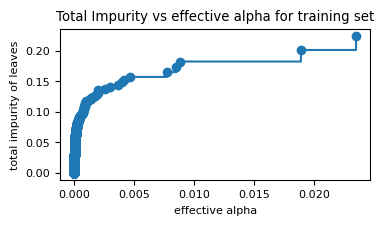

In [85]:
plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 100})
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")  # we avoid highest alpha for trivial 1 node case
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# one possible optimal value could be before the path flattens out as it leads to relatively less impurity chnage after that.

In [86]:
# we define a function for cross-validation
def cv_iter(alpha, folds, X, y):
    cart = tree.DecisionTreeRegressor(ccp_alpha = alpha)
    cv_result = cross_validate(cart, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

9.500000000000002e-05

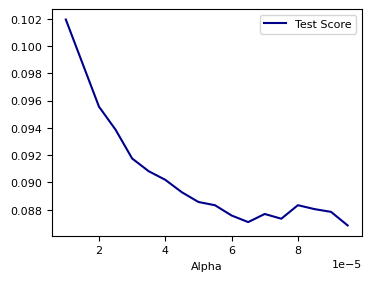

In [87]:
# might take time to run
result = {}
for i in np.arange(0.00001, 0.0001, 0.000005): # you can also try a different grid for search 
    result[i] = cv_iter(i, 3, X_train, y_train)

matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Alpha')

results['Test Score'].idxmin()

Tree depth: 13
Out-of-sample Rsq: 0.745
Out-of-sample MSE: 0.084


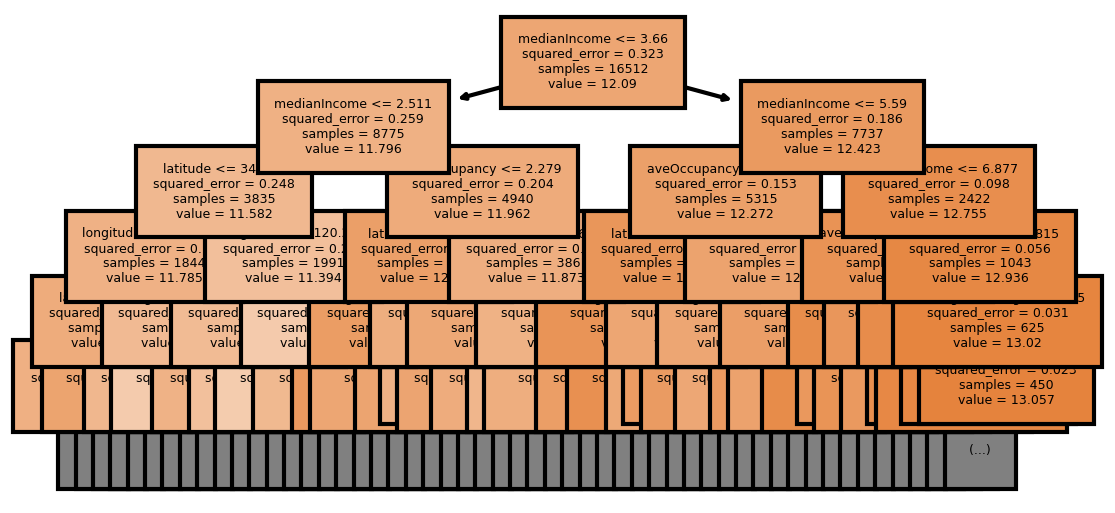

In [88]:
# we fit a tree using the optimal ccp_alpha from cv test

cart = tree.DecisionTreeRegressor( ccp_alpha = results['Test Score'].idxmin(), random_state = 1)
cart = cart.fit(X_train, y_train)

y_pred = cart.predict(X_test)

# try to change the parameters and check how the OOS performance changes
# Out-of-sample R-sq.
print('Tree depth: %.0f' % cart.get_depth())
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

#dendrogram
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize': (4, 2), 'figure.dpi': 300})
tree.plot_tree(cart, max_depth = 5, filled = True, feature_names = list(X.columns),\
               fontsize = 3);

### Random Forest

Some points to keep in mind:

* There is no strict suggestion whether we should use a stopping rule and/or pruning for individual trees.
* Thereoretically, by aggregating over many trees (even if they individually overfit), we will average-out the noise. 
* It also depends on the nature of your data (high  noise vs. low noise, the amount of data and dimensions) 
  - could apply a stopping rule if you have a small number of observations;
  - could apply a stopping rule if you have a big dataset as it gets cumbersome to fit full trees.

In [89]:
rf = ensemble.RandomForestRegressor(n_estimators = 100, min_samples_leaf = 1, min_samples_split = 2, oob_score = True, \
        random_state = 1)
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: 0.829
Out-of-sample MSE: 0.056


In [90]:
# let's add an option for extra randomization (for each individual tree, we randomly select a subsample of covariates 
# from X to split on)

rf = ensemble.RandomForestRegressor(n_estimators = 50, min_samples_leaf = 1, oob_score = True, \
        random_state = 1, max_features = int(X_train.shape[1]/3))
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Out-of-sample R-sq.
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred))

Out-of-sample Rsq: 0.833
Out-of-sample MSE: 0.055


In [91]:
# we can check whether we had enough trees in the forest
# Use cross-validation to determine the optimal number of trees

def cv_iter(n, folds, X, y):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1)
    rf = ensemble.RandomForestRegressor(n_estimators = n, min_samples_leaf = 1, \
        random_state = 1)
    cv_result = cross_validate(rf, X, y, scoring = 'neg_mean_squared_error')
    avg_score = np.mean(cv_result['test_score'])
    return float(-avg_score)

<AxesSubplot:xlabel='Number of trees'>

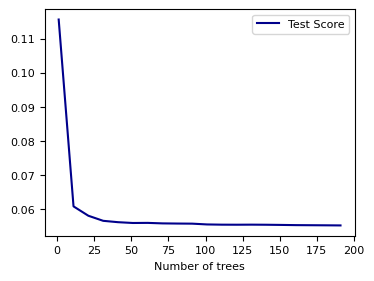

In [92]:
result = {}
for i in range(1, 200, 10):
    result[i] = cv_iter(i, 5, X_train, y_train)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (4, 3), 'figure.dpi': 100})    
results = pd.DataFrame.from_dict(result,orient='index', columns = ['Test Score'])
results.plot(color = 'DarkBlue', xlabel = 'Number of trees')

# as we can see on the graph below, the MSE stabilizes with about 50 trees. 

### Feature Importance

The property feature_importances_ is used to find out which of the covariates are the most important determinants of House values. 
We try to create a dataframe that sorts features according to their performance. 

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.feature_importances_
Sklearn calculates the impurity-based feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 


In [93]:
# we try to discover the important features
imp = pd.DataFrame(rf.feature_importances_, columns = ['Feature importance'])
imp['Feature'] = list(X.columns)
imp.sort_values(by=['Feature importance'], ascending=False).reset_index(drop = True)

,Feature importance,Feature
0,0.344901,medianIncome
1,0.174294,latitude
2,0.170600,longitude
3,0.111059,aveRooms
4,0.106483,aveOccupancy
5,0.046528,aveBedrooms
6,0.046135,housingMedianAge


In [94]:
# reaarange columns for convenience
cols = ['medianHouseValue', 'longitude', 'latitude', 'medianIncome','aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']

df_ols = df_ylog[cols]

# add a constant 
df_ols['c'] = 1

# add interaction  terms
for j in ['longitude', 'latitude', 'medianIncome','aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']:
    for i in ['longitude', 'latitude', 'medianIncome','aveRooms', 'aveBedrooms', 'aveOccupancy', 'housingMedianAge']:
        df_ols[f"{j[0:4]}_{i[0:4]}"] = df_ols[j]*df_ols[i]  
        
df_ols.head()

C:\Users\johnd\AppData\Local\Temp\ipykernel_9052\2891247256.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ols['c'] = 1
C:\Users\johnd\AppData\Local\Temp\ipykernel_9052\2891247256.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ols[f"{j[0:4]}_{i[0:4]}"] = df_ols[j]*df_ols[i]


,medianHouseValue,longitude,latitude,medianIncome,aveRooms,aveBedrooms,aveOccupancy,housingMedianAge,c,long_long,...,aveO_aveB,aveO_aveO,aveO_hous,hous_long,hous_lati,hous_medi,hous_aveR,hous_aveB,hous_aveO,hous_hous
0,13.022764,-122.23,37.88,8.3252,6.984127,1.023810,2.555556,41.0,1,14940.1729,...,2.616402,6.530864,104.777778,-5011.43,1553.08,341.3332,286.349206,41.976190,104.777778,1681.0
1,12.789684,-122.22,37.86,8.3014,6.238137,0.971880,2.109842,21.0,1,14937.7284,...,2.050514,4.451433,44.306678,-2566.62,795.06,174.3294,131.000879,20.409490,44.306678,441.0
2,12.771671,-122.24,37.85,7.2574,8.288136,1.073446,2.802260,52.0,1,14942.6176,...,3.008076,7.852660,145.717514,-6356.48,1968.20,377.3848,430.983051,55.819209,145.717514,2704.0
3,12.740517,-122.25,37.85,5.6431,5.817352,1.073059,2.547945,52.0,1,14945.0625,...,2.734096,6.492025,132.493151,-6357.00,1968.20,293.4412,302.502283,55.799087,132.493151,2704.0
4,12.743151,-122.25,37.85,3.8462,6.281853,1.081081,2.181467,52.0,1,14945.0625,...,2.358343,4.758799,113.436293,-6357.00,1968.20,200.0024,326.656371,56.216216,113.436293,2704.0


In [95]:
#OLS with seven features 
data = df_ols.copy()
X = data.iloc[:, 1:9] 
y = data['medianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

regr = LinearRegression(fit_intercept = True, copy_X=False, n_jobs=-1)
regr = regr.fit(X_train, y_train)

# to see the coefficients
print('Intercept: %.3f' %regr.intercept_)
print('Coefficients: ' )
print(regr.coef_ )

y_pred_in = regr.predict(X_train)
y_pred_out = regr.predict(X_test)
# In-sample R-sq.
print('In-sample Rsq: %.3f'
      % r2_score(y_train, y_pred_in))
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred_out))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred_out))

Intercept: -13.108
Coefficients: 
[-0.28953135 -0.28849505  0.18674869 -0.03191019  0.22698303 -0.00143934
  0.00214974  0.        ]
In-sample Rsq: 0.618
Out-of-sample Rsq: 0.597
Out-of-sample MSE: 0.132


In [96]:
# OLS with all variables
data = df_ols.copy()
X = data.iloc[:, 1:]
y = data['medianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

regr = LinearRegression(fit_intercept = True, copy_X=False, n_jobs=-1) # if we use defaults, the option can be skipped
regr = regr.fit(X_train, y_train)

y_pred_in = regr.predict(X_train)
y_pred_out = regr.predict(X_test)
# In-sample R-sq.
print('In-sample Rsq: %.3f'
      % r2_score(y_train, y_pred_in))
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred_out))
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred_out))

In-sample Rsq: 0.703
Out-of-sample Rsq: 0.689
Out-of-sample MSE: 0.102


In [97]:
#LASSO 
from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
from sklearn.pipeline import make_pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline
from sklearn.linear_model import Lasso

data = df_ols.copy()
X = data.iloc[:, 1:]
X = pd.DataFrame(np.ascontiguousarray(X.values), columns=X.columns) #for memory
y = data['medianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 


pipe = make_pipeline(StandardScaler(), 
                  Lasso(alpha=0.005, fit_intercept=True, copy_X=False, max_iter=10000))

# note alpha == lambda as in the lasso theory equation; we just take some value - it is not the optimal! 

pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

y_pred_out = pipe.predict(X_test)
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred_out))

In-sample Rsq:  0.6429
Out-of-sample Rsq:  0.6326
Out-of-sample MSE: 0.121


Computing regularization path using the lasso...
Ready


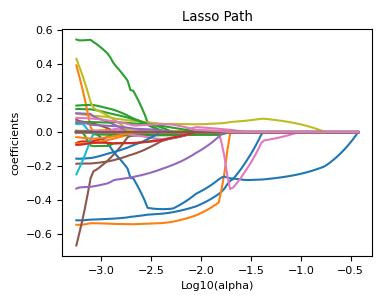

In [98]:
# lasso path
from sklearn.linear_model import lasso_path, enet_path

X = StandardScaler().fit_transform(X_train) 
# Compute paths
eps = 0.0015 #the smaller it is the longer is the path; 0 = OLS. If it is very small: the model might not find a solution
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_train, eps=eps, max_iter=10000)
print("Ready")

plt.figure()
log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log10(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')
plt.show()

In [99]:
from sklearn.linear_model import LassoCV
import time

pipe = make_pipeline(StandardScaler(),
                 LassoCV(cv=5, max_iter=10000, alphas=np.logspace(-3, -2.5, 100), fit_intercept=True))

print("Computing Lasso CV...")
t1 = time.time()
pipe.fit(X_train, y_train)
t_cv = time.time() - t1
print("Ready")

l = pipe.named_steps.lassocv #the output of lassocv step is stored here
print("Optimal alpha = % .4f " % l.alpha_)
print("Training time = % .4fs " % t_cv)

Computing Lasso CV...
Ready
Optimal alpha =  0.0027 
Training time =  12.5737s 


In [100]:
# we fit lasso using optimal alpha from cv

pipe = make_pipeline(StandardScaler(), 
                  Lasso(alpha=l.alpha_, fit_intercept=True, copy_X=False, max_iter=10000))

pipe.fit(X_train, y_train)
print('In-sample Rsq: % .4f'
     % pipe.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % pipe.score(X_test, y_test))

y_pred_out = pipe.predict(X_test)
print('Out-of-sample MSE: %.3f'
      % mean_squared_error(y_test, y_pred_out))

In-sample Rsq:  0.6532
Out-of-sample Rsq:  0.6429
Out-of-sample MSE: 0.117


In [101]:
# we can also check which coefficients were selected by LASSO 
pipe.named_steps['lasso'].coef_ # note the syntaxis pipe.named_steps

array([-4.95584666e-01, -5.40751934e-01,  2.75321290e-01, -0.00000000e+00,
        0.00000000e+00, -1.49118228e-02, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.41514814e-01,  0.00000000e+00,
       -6.99584379e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.04121156e-02,  0.00000000e+00,
       -2.49771666e-01,  0.00000000e+00,  2.89666980e-04, -0.00000000e+00,
        6.01908816e-02,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        5.18550449e-02, -0.00000000e+00, -0.00000000e+00, -1.11635687e-01,
       -1.59265667e-02,  0.00000000e+00,  4.10923909e-03, -0.00000000e+00,
       -5.15533986e-02, -0.00000000e+00,  4.96488761e-02,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        4.62847903e-02, -

In [102]:
# we add this to a new dataframe, we see all our 57 covariates
imp = pd.DataFrame(pipe.named_steps['lasso'].coef_, columns = ['Lasso coefficient'])
imp['Feature'] = list(X_train.columns)
imp

,Lasso coefficient,Feature
0,-0.495585,longitude
1,-0.540752,latitude
2,0.275321,medianIncome
3,-0.000000,aveRooms
4,0.000000,aveBedrooms
5,-0.014912,aveOccupancy
6,-0.000000,housingMedianAge
7,0.000000,c
8,0.000000,long_long
9,0.000000,long_lati


In [103]:
# we drop those LASSO coefficients with a value of zero
index = imp[(imp['Lasso coefficient'] == 0)].index
imp.drop(index, inplace=True)
imp

# these are the features selected by LASSO

,Lasso coefficient,Feature
0,-0.495585,longitude
1,-0.540752,latitude
2,0.275321,medianIncome
5,-0.014912,aveOccupancy
10,-0.241515,long_medi
12,-0.069958,long_aveB
22,-0.010412,medi_long
24,-0.249772,medi_medi
26,0.000290,medi_aveB
28,0.060191,medi_hous


### Resources 

Matt Taddy (2019) Business Data Science: Combining Machine Learning and Economics to Optimize, Automate, and Accelerate Business Decisions. McGraw-Hill Education

Hastie et al. (2017) Elements of Statistical Learning. https://web.stanford.edu/~hastie/ElemStatLearn/